In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e0c5c3dded894c5ba5219a3f64213b15')

In [6]:
search_images_bing

<function fastbook.search_images_bing>

In [7]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('conten_url')
len(ims)

150

In [8]:
dest = '/content/gdrive/MyDrive/fastbook-master/images/grizzly.jpg'
download_url(ims[0], dest)

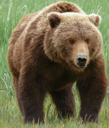

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [11]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#408) [Path('bears/black/00000059.png'),Path('bears/black/00000119.jpg'),Path('bears/black/00000080.jpg'),Path('bears/black/00000141.jpg'),Path('bears/black/00000014.jpg'),Path('bears/black/00000006.jpg'),Path('bears/black/00000073.jpg'),Path('bears/black/00000084.jpg'),Path('bears/black/00000034.jpg'),Path('bears/black/00000066.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#6) [Path('bears/black/00000147.jpg'),Path('bears/grizzly/00000011.png'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000038.jpg'),Path('bears/teddy/00000069.jpg'),Path('bears/teddy/00000063.jpg')]

In [14]:
failed.map(Path.unlink);

DL starts.

In [15]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [16]:
#doc(DataBlock)
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = parent_label,
    item_tfms= Resize(128))

In [17]:
dls = bears.dataloaders(path)

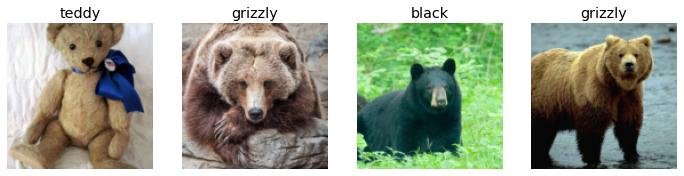

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

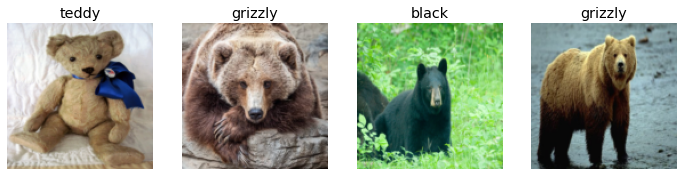

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

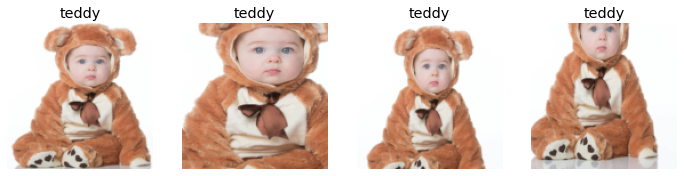

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

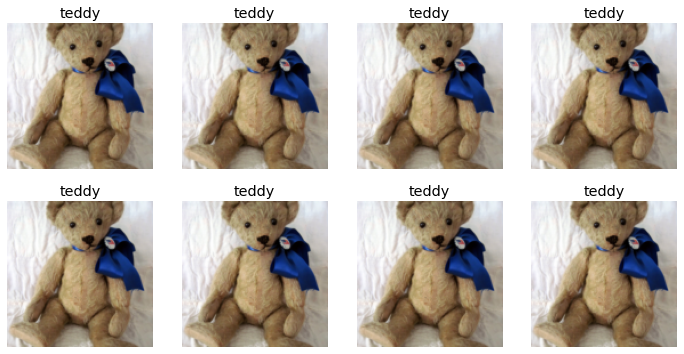

In [21]:
bears = bears.new(item_tfms = Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

Training Your Model

In [22]:
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [23]:
doc(cnn_learner)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.248807,0.052985,0.012500,00:16


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.135624,0.020899,0.000000,00:17
1,0.090497,0.021042,0.012500,00:16
2,0.062158,0.028767,0.025000,00:17
3,0.048494,0.027454,0.025000,00:16


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


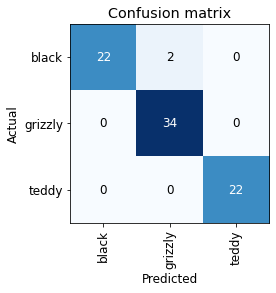

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

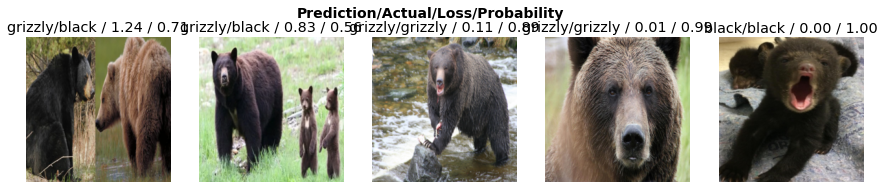

In [26]:
interp.plot_top_losses(5, nrows=1)

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Online Appication

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('/content/gdrive/MyDrive/fastbook-master/images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.5335e-06, 1.0000e+00, 1.1957e-08]))

In [32]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [37]:
pred, pred_idx, probs = learn_inf.predict(img)

In [42]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [47]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [48]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [49]:
btn_upload = widgets.FileUpload()

In [50]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

2